In [2]:
import matplotlib.pyplot as plt
import os, re
import pandas as pd
import numpy as np

from datetime import datetime as dt
import cPickle as pickle
import re #Regex
%matplotlib inline

# 1. Evaluating Crawling Indicator

In [3]:
# %time DATACrawl = pickle.load( open( "v1.4\DATA_ANALSISIS_crawl.p", "rb" ) )
%time DATACrawl = pickle.load( open( "v1.4\DATA_ANALSISIS_crawl-v2.p", "rb" ) )
crawlIndicator = pd.DataFrame([DATACrawl.crawlMem,DATACrawl.crawlTime]).transpose()
crawlIndicator.describe()

Wall time: 3.24 s


,crawlMem,crawlTime
count,13965.000000,13965.000000
mean,3252.317651,0.434459
std,701.726627,0.734470
min,2080.000000,0.000000
25%,2808.000000,0.132800
50%,2808.000000,0.156600
75%,4072.000000,0.511900
max,6832.000000,21.701800


In [4]:
DATA_ANALSISIS_crawl    = DATACrawl[DATACrawl.flag.isin([-1, 1])]
DATA_ANALSISIS_crawlPos = DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.flag == 1]
DATA_ANALSISIS_crawlNeg = DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.flag == -1]
crawlAnalysis = pd.DataFrame([DATA_ANALSISIS_crawlPos.crawlMem,DATA_ANALSISIS_crawlPos.crawlTime,
                              DATA_ANALSISIS_crawlNeg.crawlMem,DATA_ANALSISIS_crawlNeg.crawlTime]).transpose()
crawlAnalysis.columns = ['Memory Positif','Time Positif','Memory Negatif','Time Negatif']
print 'Memory Positif : ',sum(DATA_ANALSISIS_crawlPos.crawlMem), 'Byte'
print 'Memory Negatif : ',sum(DATA_ANALSISIS_crawlNeg.crawlMem), 'Byte'
print 'Time Positif   : ',sum(DATA_ANALSISIS_crawlPos.crawlTime), 'Detik'
print 'Time Negatif   : ',sum(DATA_ANALSISIS_crawlNeg.crawlTime),'Detik'
crawlAnalysis.describe()

Memory Positif :  377552.0 Byte
Memory Negatif :  45041064.0 Byte
Time Positif   :  34.7887 Detik
Time Negatif   :  6032.4353 Detik


,Memory Positif,Time Positif,Memory Negatif,Time Negatif
count,110.000000,110.000000,13855.000000,13855.000000
mean,3432.290909,0.316261,3250.888777,0.435398
std,863.851110,0.565705,700.142556,0.735595
min,2368.000000,0.046600,2080.000000,0.000000
25%,2520.000000,0.129025,2808.000000,0.132800
50%,3920.000000,0.145450,2808.000000,0.156700
75%,4072.000000,0.200300,4072.000000,0.512700
max,6832.000000,4.256200,6824.000000,21.701800


#### Terlihat total penggunaan waktu dan memory sangat signifikan, hal tersebut karena jumlah berita positif dan negatif yang berbeda jauh

# 2.Evaluating the Classifier v1.4 vs v1.6 vs v2.0


## 2.1 Load from the 'Pickled' dump

In [5]:
DATAStd  = pd.DataFrame()
DATAPost = pd.DataFrame()

#Load standard striped Text
%time DATAStd['Judul'] = pickle.load( open( "v1.4\DATA_JUDULStriped-v2.p", "rb" ) )
%time DATAStd['Short'] = pickle.load( open( "v1.4\DATA_SHORTStriped-v2.p", "rb" ) )
%time DATAStd['Long']  = pickle.load( open( "v1.4\DATA_LONGStriped-v2.p", "rb" ) )

#Load from PosTagged Noun and verb only Text
%time DATAPost['Judul'] = pickle.load( open( "v1.6\DATA_JUDULpostag-v2.p", "rb" ) )
%time DATAPost['Short'] = pickle.load( open( "v1.6\DATA_SHORTpostag-v2.p", "rb" ) )
%time DATAPost['Long']  = pickle.load( open( "v1.6\DATA_LONGpostag-v2.p", "rb" ) )

#Load number of total tag in Text
%time AllFracJudul = pickle.load( open( "v2.0\DATA_JUDUL-v3.p", "rb" ) )
%time AllFracShort = pickle.load( open( "v2.0\DATA_SHORT-v3.p", "rb" ) )
%time AllFracLong  = pickle.load( open( "v2.0\DATA_LONG-v3.p", "rb" ) )

#Load number of total noun-verb only in Text
# %time NVFracJudul = pickle.load( open( "v2.0\DATA_JUDUL-v2.p", "rb" ) )
# %time NVFracShort = pickle.load( open( "v2.0\DATA_SHORT-v2.p", "rb" ) )
# %time NVFracLong  = pickle.load( open( "v2.0\DATA_LONG-v2.p", "rb" ) )

%time DATA_TARGET = pickle.load( open( "v1.4\DATA_TARGET-v2.p", "rb" ) )

DATA_TARGET = DATA_TARGET.reset_index(drop=True)
DATAStd  = DATAStd.reset_index(drop=True)
DATAPost = DATAPost.reset_index(drop=True)

Wall time: 376 ms
Wall time: 240 ms
Wall time: 1.61 s
Wall time: 151 ms
Wall time: 157 ms
Wall time: 1.7 s
Wall time: 912 ms
Wall time: 970 ms
Wall time: 841 ms
Wall time: 141 ms


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Stopwords data source : https://www.illc.uva.nl/Research/Publications/Reports/MoL-2003-02.text.pdf
stopword_html = open("id.stopwords.01.01.2016.txt",'r').read()
stopwords     = stopword_html.split("\n")
vect1 = TfidfVectorizer(decode_error='ignore')
vect2 = TfidfVectorizer(stop_words=stopwords,decode_error='ignore')
vectStds = vect1.fit_transform(DATAStd['Long'])
vectStop = vect2.fit_transform(DATAStd['Long'])
vectPost = vect1.fit_transform(DATAPost['Long'])

In [7]:
vectStds

<12718x74069 sparse matrix of type '<type 'numpy.float64'>'
	with 2060484 stored elements in Compressed Sparse Row format>

In [8]:
vectStop

<12718x73380 sparse matrix of type '<type 'numpy.float64'>'
	with 1348999 stored elements in Compressed Sparse Row format>

In [9]:
vectPost

<12718x68937 sparse matrix of type '<type 'numpy.float64'>'
	with 1436359 stored elements in Compressed Sparse Row format>

In [10]:
print AllFracLong.shape

(12718L, 29L)


#### Data Teks berita yang sudah dibersihkan dari tag HTML di v1.4

In [11]:
DATAStd.Judul.head(2)

0    tiba di kpk, bos agung sedayu group diam serib...
1    edarkan ganja ke nelayan  &  pelajar, kardiman...
Name: Judul, dtype: object

#### Data Teks berita yang sudah di-POSTag verb dan noun di v1.6

In [12]:
DATAPost.Judul.head(2)

0    tiba kpk bos agung sedayu group diam seribu ba...
1    edarkan ganja nelayan pelajar kardiman ditangk...
Name: Judul, dtype: object

#### Data Teks berita yang sudah diambil fraction verb dan noun di v2.0

In [13]:
AllFracJudul[:2]

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]])

## 2. Evaluate

### Preprocessing

![smiley](img/evaluasi_preproc.png)

In [14]:
#Stopwords data source : https://www.illc.uva.nl/Research/Publications/Reports/MoL-2003-02.text.pdf
stopword_html = open("id.stopwords.01.01.2016.txt",'r').read()
stopwords     = stopword_html.split("\n")

In [15]:
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, classification_report, roc_auc_score,roc_curve,auc
from scipy import interp
import datetime

def skorStratCV(clf,X,y,nfolds=10):
    metrics = []
    
    trainTime,testTime = [],[]
    precis,recals,f1s,accs,rocs = [],[],[],[],[]
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    skf = cross_validation.StratifiedKFold(y, n_folds=nfolds)
    for train_index, test_index in skf:
        X_train,y_train = X[train_index],y[train_index]
        X_test,y_test   = X[test_index],y[test_index]
        
        #training time
        start = dt.now()
        clf.fit(X_train, y_train)
        end = dt.now()
        trainTime.append((end-start).microseconds)
        
        #testing time
        start = dt.now()
        yhat = clf.predict(X_test)
        end = dt.now()
        testTime.append((end-start).microseconds)
        
        #score
        precis.append(precision_score(y_test, yhat, average='binary'))
        recals.append(recall_score(y_test, yhat, average='binary'))
        f1s.append(f1_score(y_test, yhat, average='binary'))
        accs.append(accuracy_score(y_test, yhat))
        
        probas_              = clf.fit(X_train, y_train).predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        mean_tpr            += interp(mean_fpr, fpr, tpr)
        mean_tpr[0]          = 0.0
        
    def ave(lis):
        return sum(lis)/len(lis)
    
    metrics.append(ave(trainTime))
    metrics.append(ave(testTime))
    metrics.append(ave(precis))
    metrics.append(ave(recals))
    metrics.append(ave(f1s))
    metrics.append(ave(accs))
    
    mean_tpr /= nfolds
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    metrics.append(mean_auc)
    
    return metrics,mean_fpr,mean_tpr

In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

mnb = MultinomialNB(alpha=0.1)
#knn = KNeighborsClassifier()
svc = SVC(class_weight='balanced',probability=True,kernel='linear',cache_size=800)
#tre = DecisionTreeClassifier(class_weight='balanced')

vectStds = TfidfVectorizer(decode_error='ignore')
vectStop = TfidfVectorizer(stop_words=stopwords,decode_error='ignore')

kombinasi13 = [{'name' : 'MNB', 'pipe' : Pipeline([('vect', vectStds),('clf', mnb)])},
               #{'name' : 'KNN', 'pipe' : Pipeline([('vect', vect),('clf', knn)])},
               {'name' : 'SVM', 'pipe' : Pipeline([('vect', vectStds),('clf', svc)])},
               #{'name' : 'TREE', 'pipe' : Pipeline([('vect', vect),('clf', tre)])}
              ]

kombinasi2 = [{'name' : 'MNB', 'pipe' : Pipeline([('vect', vectStop),('clf', mnb)])},
             #{'name' : 'KNN', 'pipe' : Pipeline([('vect', vect),('clf', knn)])},
             {'name' : 'SVM', 'pipe' : Pipeline([('vect', vectStop),('clf', svc)])},
             #{'name' : 'TREE', 'pipe' : Pipeline([('vect', vect),('clf', tre)])}
             ]

kombinasi4 = [{'name' : 'MNB', 'pipe' : mnb},
               {'name' : 'SVM', 'pipe' : svc},
             ]

In [17]:
X0 = []
X0.append({'name':'Judul','Prep':'Kombinasi1','Data':DATAStd['Judul']})
X0.append({'name':'Short','Prep':'Kombinasi1','Data':DATAStd['Short']})
X0.append({'name':'Long' ,'Prep':'Kombinasi1','Data':DATAStd['Long']})

X1 = []
X1.append({'name':'Judul','Prep':'Kombinasi2','Data':DATAStd['Judul']})
X1.append({'name':'Short','Prep':'Kombinasi2','Data':DATAStd['Short']})
X1.append({'name':'Long' ,'Prep':'Kombinasi2','Data':DATAStd['Long']})

X2 = []
X2.append({'name':'Judul','Prep':'Kombinasi3','Data':DATAPost['Judul']})
X2.append({'name':'Short','Prep':'Kombinasi3','Data':DATAPost['Short']})
X2.append({'name':'Long' ,'Prep':'Kombinasi3','Data':DATAPost['Long']})

X3 = []
X3.append({'name':'Judul','Prep':'Kombinasi4','Data':AllFracJudul})
X3.append({'name':'Short','Prep':'Kombinasi4','Data':AllFracShort})
X3.append({'name':'Long' ,'Prep':'Kombinasi4','Data':AllFracLong})
# X2.append({'name':'Judul','Prep':'NVTag','Data':NVFracJudul})
# X2.append({'name':'Short','Prep':'NVTag','Data':NVFracShort})
# X2.append({'name':'Long' ,'Prep':'NVTag','Data':NVFracLong})

y_  = DATA_TARGET

#We only use 5% of total negative instance
factor = 5.0/100
size   = int(factor*DATA_TARGET[DATA_TARGET.values == -1].count())
print 'Total Negative Instances    : ',DATA_TARGET[DATA_TARGET.values == -1].count()
print 'Training Negative Instances : ',size
print 'Training Positif Instances  : ',DATA_TARGET[DATA_TARGET.values == 1].count()

Total Negative Instances    :  12609
Training Negative Instances :  630
Training Positif Instances  :  109


## Kombinasi 1

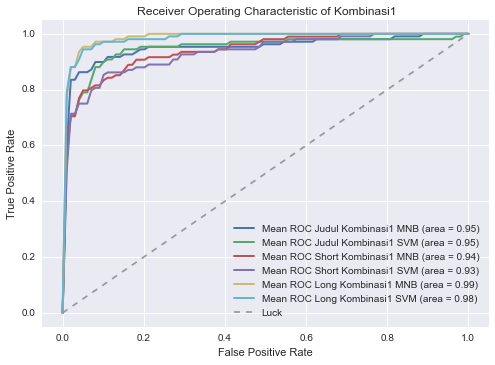

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

metric = []
for xi in X0:
    X_ = xi['Data']
    for mod in kombinasi13:
        xP = X_[y_[y_.values == 1].index]
        xN = X_[y_[y_.values == -1].index][:size]
        X  = np.append(xP,xN)
        
        yP = y_[y_.values == 1]
        yN = y_[y_.values == -1][:size]
        y  = np.append(yP,yN)
        
        metrics,mean_fpr,mean_tpr = skorStratCV(mod['pipe'],X,y)
        name = xi['name']+' '+xi['Prep']+' '+mod['name']
        plt.plot(mean_fpr, mean_tpr,label='Mean ROC %s (area = %0.2f)' % (name,metrics[6]), lw=2)
        
        metric.append({'name':name,'metrics':metrics})

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Kombinasi1')
plt.legend(loc="lower right")
plt.show()

## Kombinasi 2

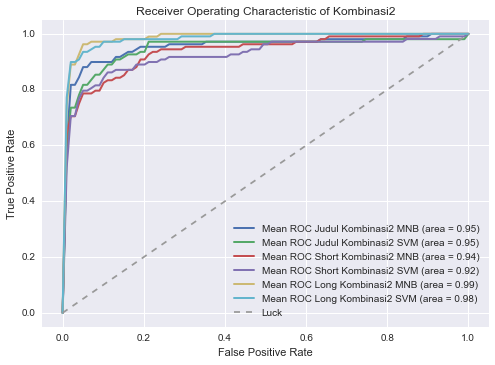

In [19]:
#metric = []
for xi in X1:
    X_ = xi['Data']
    for mod in kombinasi2:
        xP = X_[y_[y_.values == 1].index]
        xN = X_[y_[y_.values == -1].index][:size]
        X  = np.append(xP,xN)
        
        yP = y_[y_.values == 1]
        yN = y_[y_.values == -1][:size]
        y  = np.append(yP,yN)
        
        metrics,mean_fpr,mean_tpr = skorStratCV(mod['pipe'],X,y)
        name = xi['name']+' '+xi['Prep']+' '+mod['name']
        plt.plot(mean_fpr, mean_tpr,label='Mean ROC %s (area = %0.2f)' % (name,metrics[6]), lw=2)
        
        metric.append({'name':name,'metrics':metrics})

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Kombinasi2')
plt.legend(loc="lower right")
plt.show()

## Kombinasi 3

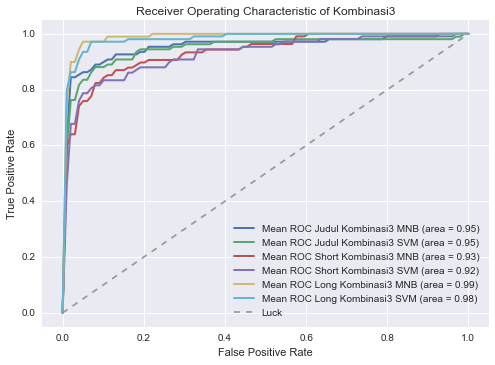

In [20]:
#metric = []
for xi in X2:
    X_ = xi['Data']
    for mod in kombinasi13:
        xP = X_[y_[y_.values == 1].index]
        xN = X_[y_[y_.values == -1].index][:size]
        X  = np.append(xP,xN)
        
        yP = y_[y_.values == 1]
        yN = y_[y_.values == -1][:size]
        y  = np.append(yP,yN)
        
        metrics,mean_fpr,mean_tpr = skorStratCV(mod['pipe'],X,y)
        name = xi['name']+' '+xi['Prep']+' '+mod['name']
        plt.plot(mean_fpr, mean_tpr,label='Mean ROC %s (area = %0.2f)' % (name,metrics[6]), lw=2)
        
        metric.append({'name':name,'metrics':metrics})

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Kombinasi3')
plt.legend(loc="lower right")
plt.show()

## Kombinasi 4

C:\Users\Thosan Girisona S\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Thosan Girisona S\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


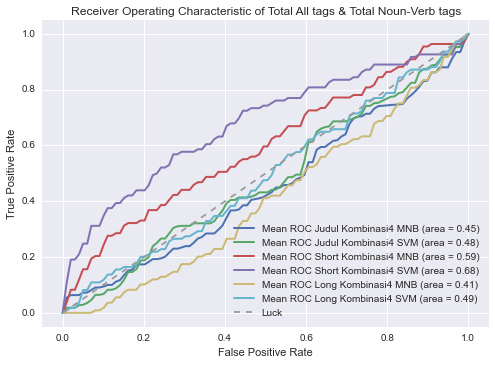

In [21]:
#metric = []
for xi in X3:
    X_ = xi['Data']
    for mod in kombinasi4:
        xP = X_[y_[y_.values == 1].index]
        xN = X_[y_[y_.values == -1].index][:size]
        X  = np.vstack((xP,xN))
        
        yP = y_[y_.values == 1]
        yN = y_[y_.values == -1][:size]
        y  = np.append(yP,yN)
        
        metrics,mean_fpr,mean_tpr = skorStratCV(mod['pipe'],X,y)
        name = xi['name']+' '+xi['Prep']+' '+mod['name']
        plt.plot(mean_fpr, mean_tpr,label='Mean ROC %s (area = %0.2f)' % (name,metrics[6]), lw=2)
        
        metric.append({'name':name,'metrics':metrics})

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Total All tags & Total Noun-Verb tags')
plt.legend(loc="lower right")
plt.show()

In [22]:
from ipy_table import *
metrics_table = []
tables = []
columns = (['id', 'nama','training time', 'testing time','p_1',
            'r_1','F1 score','accuracy','AUC'])
tables.append(columns)

i = 0

for me in metric:
    i += 1
    
    metr = []
    metr.append(i)
    metr.append(me['name'])
    for m in me['metrics']:
        metr.append(m)

    tables.append(metr)
    metrics_table.append(metr)
    #print metric
    
make_table(tables)

# styling
apply_theme('basic_both')
set_column_style(7, align='center')

id,nama,training time,testing time,p_1,r_1,F1 score,accuracy,AUC
1,Judul Kombinasi1 MNB,20100,2300,0.8588,0.7691,0.7948,0.9418,0.9502
2,Judul Kombinasi1 SVM,269400,5400,0.7877,0.7691,0.7576,0.9283,0.9459
3,Short Kombinasi1 MNB,32900,2900,0.9032,0.6482,0.7274,0.9337,0.9391
4,Short Kombinasi1 SVM,353700,8400,0.8353,0.6955,0.7350,0.9296,0.9300
5,Long Kombinasi1 MNB,336900,40800,0.9536,0.7591,0.8344,0.9580,0.9857
6,Long Kombinasi1 SVM,494800,97100,0.9268,0.8609,0.8855,0.9675,0.9831
7,Judul Kombinasi2 MNB,19900,2500,0.8306,0.7873,0.7985,0.9404,0.9536
8,Judul Kombinasi2 SVM,210100,5100,0.8082,0.7882,0.7793,0.9324,0.9453
9,Short Kombinasi2 MNB,26600,3500,0.8589,0.7127,0.7603,0.9364,0.9357
10,Short Kombinasi2 SVM,260500,6500,0.8112,0.7136,0.7400,0.9283,0.9229


In [23]:
evals = pd.DataFrame(metrics_table,columns=columns)
evals['Vars'] = [i.split()[0] for i in evals['nama']]
evals['Prep'] = [i.split()[1] for i in evals['nama']]
evals['Algs'] = [i.split()[2] for i in evals['nama']]
evals.drop('nama',axis=1,inplace=True)
evals.drop('id',axis=1,inplace=True)

In [24]:
splitter = ['Judul','Short','Long']
eval_teks = pd.DataFrame([evals[evals.Vars == i].mean() for i in splitter]).transpose()
eval_teks.set_axis(1,splitter)
eval_teks

,Judul,Short,Long
training time,105687.500000,144262.500000,338937.500000
testing time,3000.000000,3787.500000,39675.000000
p_1,0.663087,0.688754,0.716353
r_1,0.648068,0.593523,0.664545
F1 score,0.624152,0.609295,0.673478
accuracy,0.875854,0.893748,0.894264
AUC,0.828157,0.856973,0.850648


In [25]:
splitter = ['Kombinasi1','Kombinasi2','Kombinasi3','Kombinasi4']
eval_prep = pd.DataFrame([evals[evals.Prep == i].mean() for i in splitter]).transpose()
eval_prep.set_axis(1,splitter)
eval_prep

,Kombinasi1,Kombinasi2,Kombinasi3,Kombinasi4
training time,251300.000000,191066.666667,198583.333333,144233.333333
testing time,26150.000000,19366.666667,15650.000000,783.333333
p_1,0.877570,0.861678,0.868976,0.149367
r_1,0.750303,0.777879,0.782576,0.230758
F1 score,0.789124,0.802944,0.809453,0.141045
accuracy,0.943151,0.944508,0.946760,0.717401
AUC,0.955684,0.954097,0.954560,0.516696


In [26]:
splitter = ['MNB','SVM']
eval_teks = pd.DataFrame([evals[evals.Algs == i].mean() for i in splitter]).transpose()
eval_teks.set_axis(1,splitter)
eval_teks

,MNB,SVM
training time,86458.333333,306133.333333
testing time,9441.666667,21533.333333
p_1,0.693201,0.685594
r_1,0.571742,0.699015
F1 score,0.607695,0.663588
accuracy,0.922291,0.853619
AUC,0.839909,0.850610


In [27]:
mnb

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [28]:
#knn
# knn_params = {'n_neighbors': range(1,21), 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree'],
#               'leaf_size': [15, 30, 50, 100], 'p': [1,2]}

In [29]:
svc
# lsvm_params = {'loss':['hinge', 'squared_hinge'],'class_weight':['balanced']}

SVC(C=1.0, cache_size=800, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
#tre
# tree_param = {"criterion": ["gini", "entropy"],"class_weight" : ['balanced']}